In [1]:
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import vgg19

os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
from IPython.display import display, Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import PIL
from PIL import Image as PILImage
import time
import functools

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]

  return PIL.Image.fromarray(tensor)

In [4]:
image_path = tf.keras.utils.get_file('zlatan.jpg', 'https://e0.365dm.com/21/02/1600x900/skysports-zlatan-ibrahimovic_5266629.jpg?20210209092723')
style_path = tf.keras.utils.get_file('zlatan.jpg', 'https://e0.365dm.com/21/02/1600x900/skysports-zlatan-ibrahimovic_5266629.jpg?20210209092723')
# style_path = tf.keras.utils.get_file('cubism.jpg', 'https://cdn.britannica.com/21/181721-050-4EC50715/Les-Demoiselles-dAvignon-Oil-painting-canvas-The.jpg')

In [5]:
def load_image(path_to_image):
  max_dim = 512
  img = tf.io.read_file(path_to_image)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim/long_dim

  new_shape = tf.cast(shape*scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]

  return img

In [6]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

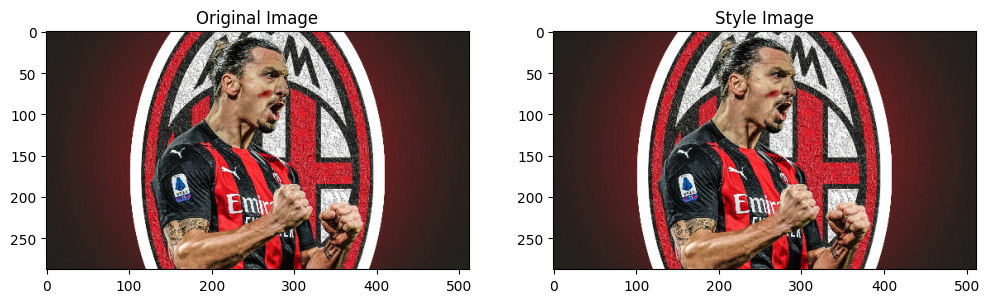

In [7]:
content_image = load_image(image_path)
style_image = load_image(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, "Original Image")

plt.subplot(1, 2, 2)
imshow(style_image, "Style Image")

# Pre-trained Model

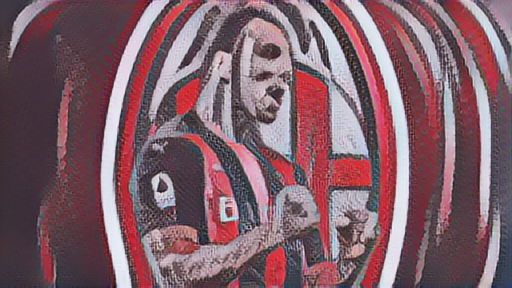

In [8]:
import tensorflow_hub as hub

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

tensor_to_image(stylized_image)

# Costum Model Using VGG19

In [9]:
# Define the desired dimensions for the generated image
width, height = keras.utils.load_img(image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [10]:
# Preprocess the image
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


In [11]:
# Convert the generated image back to its original format
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


# Build the feature extractor

In [16]:
# Load the VGG19 model pre-trained on ImageNet
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
  print(layer.name, layer)

input_1 <keras.src.engine.input_layer.InputLayer object at 0x7d89bd897460>
block1_conv1 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d89bd71c700>
block1_conv2 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d89bd71dea0>
block1_pool <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7d89bd71c9d0>
block2_conv1 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d89bd71dcf0>
block2_conv2 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d89bd71f280>
block2_pool <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7d89bd71e410>
block3_conv1 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d89bd8969b0>
block3_conv2 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d89bd71f3a0>
block3_conv3 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d89bd71faf0>
block3_conv4 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d89bd798a00>
block3_pool <keras.src.layers.pooling.max_pooling2d.MaxPooling2

In [17]:
# Define the style layer names and content layer name
content_layer_name = 'block5_conv2'

style_layer_names = ['block1_conv1',
                     'block1_pool',
                     'block2_conv1',
                     'block4_pool',
                     'block3_conv1',
                     'block3_pool',
                     'block4_conv1',
                     'block4_pool',
                     'block5_conv1']


We can now setup our model to output the selected layers.

In [18]:
# Define the VGG19 model pre-trained on ImageNet
def feature_extractor():
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  style_layers = [vgg.get_layer('block1_conv1'),
                  vgg.get_layer('block1_pool'),
                  vgg.get_layer('block2_conv1'),
                  vgg.get_layer('block2_pool'),
                  vgg.get_layer('block3_conv1'),
                  vgg.get_layer('block3_pool'),
                  vgg.get_layer('block4_conv1'),
                  vgg.get_layer('block4_pool'),
                  vgg.get_layer('block5_conv1'),
                  vgg.get_layer('block5_conv2')]

  # Create a dictionary mapping layer names to their outputs
  outputs_dict = dict([(layer.name, layer.output) for layer in style_layers])

  outputs = [vgg.get_layer(name).output for name in outputs_dict]
  model = keras.Model(inputs=vgg.inputs, outputs=outputs_dict)

  return model

In [19]:
# Create a dictionary mapping layer names to their outputs
outputs_dict = dict([(layer.name, layer.output) for layer in vgg.layers])

# Build a feature extraction model using VGG19
feature_extractor = feature_extractor()

In [20]:
# Set the weights for loss calculation
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8


# Calculate content loss

In [14]:
# Calculate the content loss between a base image and a combination image
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# Calculate the gram matrix

In [12]:
# Calculate the Gram matrix for a given tensor
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# Calculate style loss

In [13]:
# Calculate the style loss between a style image and a combination image
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


In [15]:
# Calculate the total variation loss for a given image
def total_variation_loss(x):
    a = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :])
    b = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))


# Compute the total loss for the combination image

$L_{total} = \beta L_{style} + \alpha L_{content}$

In [21]:
# Compute the total loss for the combination image
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


# Calculate gradients

In [22]:
# Compute the loss and gradients for the combination image
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads


In [33]:
# Set the optimizer with a learning rate decay
optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=90.0, decay_steps=100, decay_rate=0.99))


# Preprocess the base image, style reference image, and combination image
base_image = preprocess_image(image_path)
style_reference_image = preprocess_image(style_path)
combination_image = tf.Variable(preprocess_image(image_path))

# Set the prefix for saving the generated images
result_prefix = "generated"

# Set the number of iterations for optimization
iterations = 4000


In [34]:
# Perform the style transfer optimization loop
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)


Iteration 100: loss=6367.17
Iteration 200: loss=4651.33
Iteration 300: loss=4099.71
Iteration 400: loss=3828.02
Iteration 500: loss=3661.53
Iteration 600: loss=3546.64
Iteration 700: loss=3461.37
Iteration 800: loss=3395.23
Iteration 900: loss=3341.95
Iteration 1000: loss=3297.89
Iteration 1100: loss=3260.73
Iteration 1200: loss=3228.92
Iteration 1300: loss=3201.12
Iteration 1400: loss=3176.65
Iteration 1500: loss=3154.83
Iteration 1600: loss=3135.17
Iteration 1700: loss=3117.42
Iteration 1800: loss=3101.30
Iteration 1900: loss=3086.56
Iteration 2000: loss=3072.99
Iteration 2100: loss=3060.45
Iteration 2200: loss=3048.84
Iteration 2300: loss=3038.00
Iteration 2400: loss=3027.90
Iteration 2500: loss=3018.48
Iteration 2600: loss=3009.64
Iteration 2700: loss=3001.29
Iteration 2800: loss=2993.47
Iteration 2900: loss=2986.06
Iteration 3000: loss=2979.05
Iteration 3100: loss=2972.40
Iteration 3200: loss=2966.08
Iteration 3300: loss=2960.06
Iteration 3400: loss=2954.31
Iteration 3500: loss=29